# Transform OpenAPI apis into MCP tools using Bedrock AgentCore Gateway

## Overview
Customers can bring OpenAPI spec in JSON or YAML and transform the apis into MCP tools using Bedrock AgentCore Gateway. We will demonstrate building a Open Weather agent that calls OpenWeather's Open APIs using API key. 

The Gateway workflow involves the following steps to connect your agents to external tools:
* **Create the tools for your Gateway** - Define your tools using schemas such as OpenAPI specifications for REST APIs. The OpenAPI specifications are then parsed by Amazon Bedrock AgentCore for creating the Gateway.
* **Create a Gateway endpoint** - Create the gateway that will serve as the MCP entry point with inbound authentication.
* **Add targets to your Gateway** - Configure the OpenAPI targets that define how the gateway routes requests to specific tools. All the APIs that part of OpenAPI file will become an MCP-compatible tool, and will be made available through your Gateway endpoint URL. Configure outbound authorization for each OpenAPI Gateway target. 
* **Update your agent code** - Connect your agent to the Gateway endpoint to access all configured tools through the unified MCP interface.

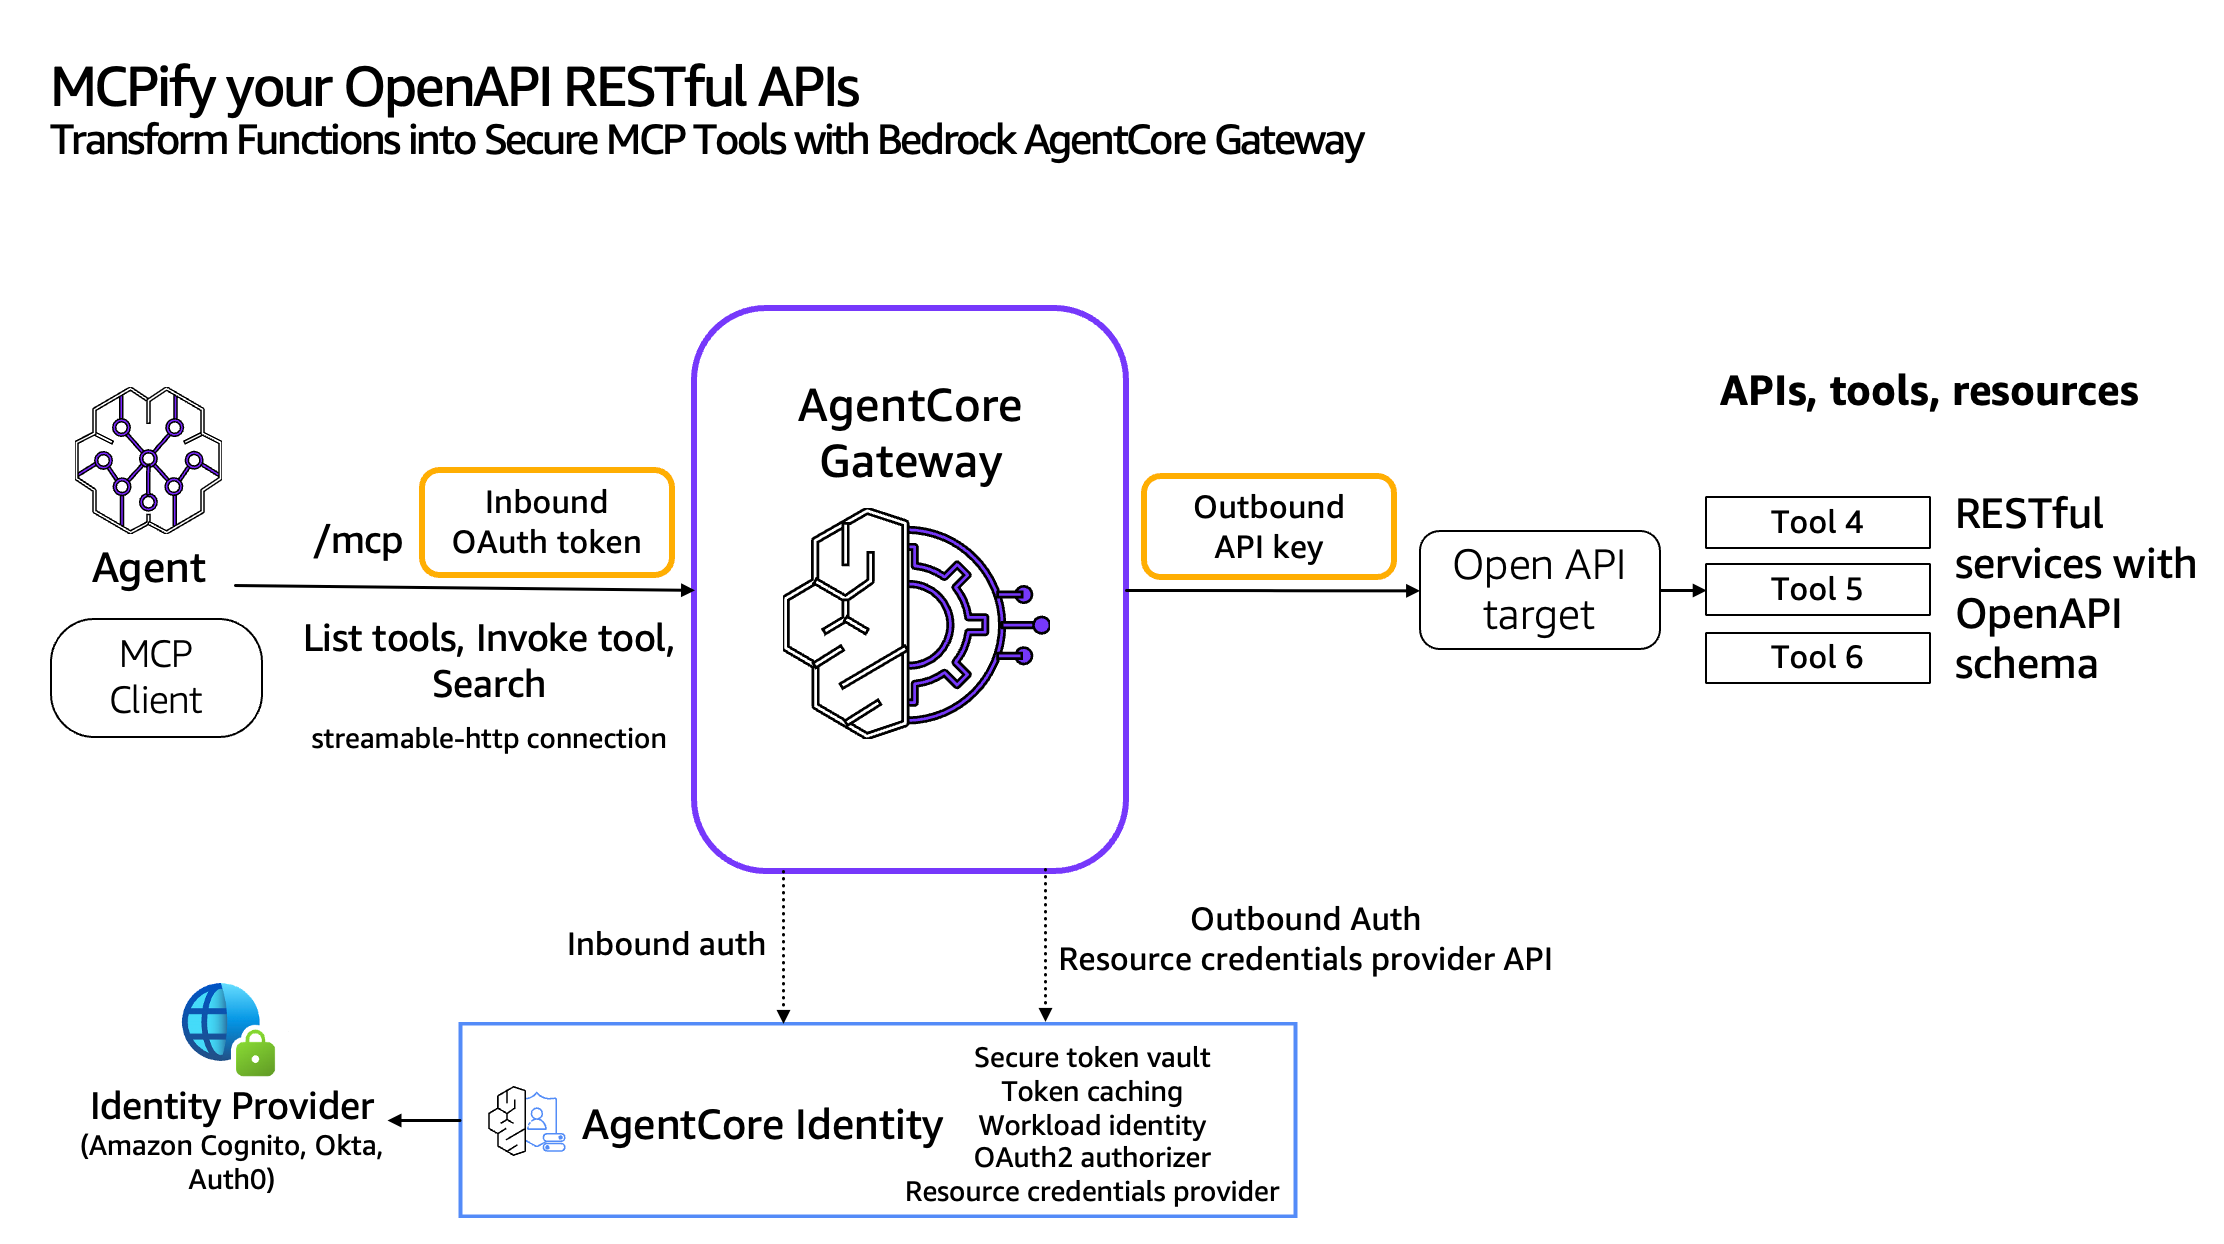

### Tutorial Details


| Information          | Details                                                   |
|:---------------------|:----------------------------------------------------------|
| Tutorial type        | Interactive                                               |
| AgentCore components | AgentCore Gateway, AgentCore Identity                     |
| Agentic Framework    | Strands Agents                                            |
| Gateway Target type  | OpenAPI                                                   |
| Agent                | Outfit Recommedation agent                                        |
| Inbound Auth IdP     | Amazon Cognito                                            |
| Outbound Auth        | API Key                                                   |
| LLM model            | Anthropic Claude Sonnet 3.7, Amazon Nova Pro              |
| Tutorial components  | Creating AgentCore Gateway and Invoking AgentCore Gateway |
| Tutorial vertical    | Cross-vertical                                            |
| Example complexity   | Easy                                                      |
| SDK used             | boto3                                                     |

In the first part of the tutorial we will create some AmazonCore Gateway targets

### Tutorial Architecture
In this tutorial we will transform operations defined in OpenAPI yaml/json file into MCP tools and host it in Bedrock AgentCore Gateway.
For demonstration purposes, we will build a Weather agent that answers queries related to weather. The agent uses Open APIs of Weather. The solution uses Strands Agent using Amazon Bedrock models
In our example we will use a very simple agent with tools for weather and outfit.

## Prerequisites

To execute this tutorial you will need:
* Jupyter notebook (Python kernel)
* uv
* AWS credentials
* Amazon Cognito

In [ ]:

!pip install --force-reinstall -U -r requirements.txt --quiet

In [ ]:
# Set AWS credentials if not using Amazon SageMaker notebook
import os
# os.environ['AWS_ACCESS_KEY_ID'] = '' # Set the access key
# os.environ['AWS_SECRET_ACCESS_KEY'] = '' # Set the secret key
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

In [ ]:
import os
import sys

# Get the current directory (utils.py is in the same directory)
current_dir = os.getcwd()

# Add current directory to sys.path if not already there
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Now you can import utils
import utils

In [ ]:
#### Create an IAM role for the Gateway to assume
import importlib
import utils
importlib.reload(utils)

agentcore_gateway_iam_role = utils.create_agentcore_gateway_role("sample-gateway")
print("Agentcore gateway role ARN: ", agentcore_gateway_iam_role['Role']['Arn'])

# Create or Retrieve Amazon Cognito Pool for Inbound authorization to Gateway

In [ ]:
# Creating Cognito User Pool 
import os
import boto3
import requests
import time
from botocore.exceptions import ClientError

REGION = os.environ['AWS_DEFAULT_REGION']
USER_POOL_NAME = "sample-agentcore-gateway-pool"
RESOURCE_SERVER_ID = "sample-agentcore-gateway-id"
RESOURCE_SERVER_NAME = "sample-agentcore-gateway-name"
CLIENT_NAME = "sample-agentcore-gateway-client"
SCOPES = [
    {"ScopeName": "gateway:read", "ScopeDescription": "Read access"},
    {"ScopeName": "gateway:write", "ScopeDescription": "Write access"}
]
scopeString = f"{RESOURCE_SERVER_ID}/gateway:read {RESOURCE_SERVER_ID}/gateway:write"

cognito = boto3.client("cognito-idp", region_name=REGION)

print("Creating or retrieving Cognito resources...")
user_pool_id = utils.get_or_create_user_pool(cognito, USER_POOL_NAME)
print(f"User Pool ID: {user_pool_id}")

utils.get_or_create_resource_server(cognito, user_pool_id, RESOURCE_SERVER_ID, RESOURCE_SERVER_NAME, SCOPES)
print("Resource server ensured.")

client_id, client_secret  = utils.get_or_create_m2m_client(cognito, user_pool_id, CLIENT_NAME, RESOURCE_SERVER_ID)
print(f"Client ID: {client_id}")

# Get discovery URL  
cognito_discovery_url = f'https://cognito-idp.{REGION}.amazonaws.com/{user_pool_id}/.well-known/openid-configuration'
print(cognito_discovery_url)

# Create or Retrieve the AgentCore Gateway 

In [ ]:
%store -r 
%store

In [ ]:
import boto3
from botocore.exceptions import ClientError

gateway_client = boto3.client('bedrock-agentcore-control', region_name = os.environ['AWS_DEFAULT_REGION'])

# Create a Gateway
auth_config = {
    "customJWTAuthorizer": { 
        "allowedClients": [client_id],  # Client MUST match with the ClientId configured in Cognito
        "discoveryUrl": cognito_discovery_url
    }
}

gateway_name = 'TestGWforOpenAPI'
gateway_id = None
gateway_url = None

# Check if gateway already exists
try:
    # List all gateways to check if one with the same name exists
    list_response = gateway_client.list_gateways()
    existing_gateway = None
    
    for gateway in list_response.get('items', []):
        if gateway['name'] == gateway_name:
            existing_gateway = gateway
            break
    
    if existing_gateway:
        print(f"Gateway '{gateway_name}' already exists. Retrieving existing gateway...")
        gateway_id = existing_gateway['gatewayId']
        # Get full gateway details to retrieve gatewayUrl
        gateway_details = gateway_client.get_gateway(gatewayIdentifier=gateway_id)
        gateway_url = gateway_details['gatewayUrl']
        print(f"Retrieved existing Gateway ID: {gateway_id}")
        print(f"Retrieved existing Gateway URL: {gateway_url}")
    else:
        print(f"Creating new gateway '{gateway_name}'...")
        create_response = gateway_client.create_gateway(
            name=gateway_name,
            roleArn = agentcore_gateway_iam_role['Role']['Arn'],
            protocolType='MCP',
            authorizerType='CUSTOM_JWT',
            authorizerConfiguration=auth_config, 
            description='AgentCore Gateway with OpenAPI target type'
        )
        
        print(create_response)
        # Retrieve the GatewayID used for GatewayTarget creation
        gateway_id = create_response["gatewayId"]
        gateway_url = create_response["gatewayUrl"]
        print(f"Created new Gateway ID: {gateway_id}")
        print(f"Created new Gateway URL: {gateway_url}")
        
except ClientError as e:
    if e.response['Error']['Code'] == 'ConflictException':
        print(f"Gateway '{gateway_name}' already exists. Attempting to retrieve...")
        # If list_gateways failed to find it but create failed with conflict, 
        # we need to handle this edge case
        list_response = gateway_client.list_gateways()
        for gateway in list_response.get('items', []):
            if gateway['name'] == gateway_name:
                gateway_id = gateway['gatewayId']
                # Get full gateway details to retrieve gatewayUrl
                gateway_details = gateway_client.get_gateway(gatewayIdentifier=gateway_id)
                gateway_url = gateway_details['gatewayUrl']
                print(f"Retrieved Gateway ID: {gateway_id}")
                print(f"Retrieved Gateway URL: {gateway_url}")
                break
    else:
        print(f"Error creating gateway: {e}")
        raise

# Final output - always print the gateway information
if gateway_id and gateway_url:
    print(f"\n=== Final Gateway Information ===")
    print(f"Gateway ID: {gateway_id}")
    print(f"Gateway URL: {gateway_url}")
else:
    print("Error: Could not retrieve or create gateway")

# Transforming Weather Open APIs into MCP tools using Bedrock AgentCore Gateway

We are going to have a Weather agent getting weather data from OpenWeather's Open APIs. You will need to register for Weather Insight API [here](https://openweathermap.org/). It's free! Once you register, you will get an API Key in your email. Use the API key to configure the credentials provider for creating the OpenAPI target.

In [ ]:
import boto3
from pprint import pprint
from botocore.config import Config

acps = boto3.client(service_name="bedrock-agentcore-control")

response=acps.create_api_key_credential_provider(
    name="OpenWeatherAPIKey",
    apiKey="<api key>", # Get an API key by signing up at openweathermap.org. Takes 2-min to get an API key in your email.
)

response=acps.get_api_key_credential_provider(name="OpenWeatherAPIKey")

pprint(response)
credentialProviderARN = response['credentialProviderArn']
pprint(f"Egress Credentials provider ARN, {credentialProviderARN}")

# Create an OpenAPI target 

#### Upload the Open API json file in S3

In [ ]:
# Create an S3 client
session = boto3.session.Session()
s3_client = session.client('s3')
sts_client = session.client('sts')

# Retrieve AWS account ID and region
account_id = sts_client.get_caller_identity()["Account"]
region = session.region_name
# Define parameters
# Your s3 bucket to upload the OpenAPI json file.
bucket_name = f'agentcore-gateway-{account_id}-{region}'
file_path = 'openweather_openapi.json'
object_key = 'openweather_openapi.json'
# Upload the file using put_object and read response
try:
    if region == "us-east-1":
        s3bucket = s3_client.create_bucket(
            Bucket=bucket_name
        )
    else:
        s3bucket = s3_client.create_bucket(
            Bucket=bucket_name,
            CreateBucketConfiguration={
                'LocationConstraint': region
            }
        )
    with open(file_path, 'rb') as file_data:
        response = s3_client.put_object(
            Bucket=bucket_name,
            Key=object_key,
            Body=file_data
        )

    # Construct the ARN of the uploaded object with account ID and region
    openapi_s3_uri = f's3://{bucket_name}/{object_key}'
    print(f'Uploaded object S3 URI: {openapi_s3_uri}')
except Exception as e:
    print(f'Error uploading file: {e}')

#### Configure outbound auth and Create the gateway target

In [ ]:
with open(file_path, 'rb') as file_data:
    response = s3_client.put_object(
        Bucket=bucket_name,
        Key=object_key,
        Body=file_data
    )

# Construct the ARN of the uploaded object with account ID and region
openapi_s3_uri = f's3://{bucket_name}/{object_key}'
print(f'Uploaded object S3 URI: {openapi_s3_uri}')

In [ ]:
# S3 Uri for OpenAPI spec file
Weather_openapi_s3_target_config = {
    "mcp": {
          "openApiSchema": {
              "s3": {
                  "uri": openapi_s3_uri
              }
          }
      }
}

# API Key credentials provider configuration
api_key_credential_config = [
    {
        "credentialProviderType" : "API_KEY", 
        "credentialProvider": {
            "apiKeyCredentialProvider": {
                    "credentialParameterName": "appid", # Replace this with the name of the api key name expected by the respective API provider. For passing token in the header, use "Authorization"
                    "providerArn": credentialProviderARN,
                    "credentialLocation":"QUERY_PARAMETER", # Location of api key. Possible values are "HEADER" and "QUERY_PARAMETER".
                    #"credentialPrefix": " " # Prefix for the token. Valid values are "Basic". Applies only for tokens.
            }
        }
    }
  ]

targetname='DemoOpenAPITargetS3OpenWeather'
response = gateway_client.create_gateway_target(
    gatewayIdentifier=gateway_id,
    name=targetname,
    description='OpenAPI Target with S3Uri using SDK',
    targetConfiguration=Weather_openapi_s3_target_config,
    credentialProviderConfigurations=api_key_credential_config)

# Calling Bedrock AgentCore Gateway from a Strands Agent

The Strands agent seamlessly integrates with AWS tools through the Bedrock AgentCore Gateway, which implements the Model Context Protocol (MCP) specification. This integration enables secure, standardized communication between AI agents and AWS services.

At its core, the Bedrock AgentCore Gateway serves as a protocol-compliant Gateway that exposes fundamental MCP APIs: ListTools and InvokeTools. These APIs allow any MCP-compliant client or SDK to discover and interact with available tools in a secure, standardized way. When the Strands agent needs to access AWS services, it communicates with the Gateway using these MCP-standardized endpoints.

The Gateway's implementation adheres strictly to the (MCP Authorization specification)[https://modelcontextprotocol.org/specification/draft/basic/authorization], ensuring robust security and access control. This means that every tool invocation by the Strands agent goes through authorization step, maintaining security while enabling powerful functionality.

For example, when the Strands agent needs to access MCP tools, it first calls ListTools to discover available tools, then uses InvokeTools to execute specific actions. The Gateway handles all the necessary security validations, protocol translations, and service interactions, making the entire process seamless and secure.

This architectural approach means that any client or SDK that implements the MCP specification can interact with AWS services through the Gateway, making it a versatile and future-proof solution for AI agent integrations.

# Request the access token from Amazon Cognito for inbound authorization

In [ ]:
print("Requesting the access token from Amazon Cognito authorizer...May fail for some time till the domain name propogation completes")
token_response = utils.get_token(user_pool_id, client_id, client_secret,scopeString,REGION)
token = token_response["access_token"]
print("Token response:", token)

# Ask outfit recommendation agent by calling Open APIs and Lambda using Bedrock AgentCore Gateway

In [ ]:
from strands.models import BedrockModel
from mcp.client.streamable_http import streamablehttp_client 
from strands.tools.mcp.mcp_client import MCPClient
from strands import Agent

def create_streamable_http_transport():
    return streamablehttp_client(gateway_url,headers={"Authorization": f"Bearer {token}"})

client = MCPClient(create_streamable_http_transport)

## The IAM group/user/ configured in ~/.aws/credentials should have access to Bedrock model
yourmodel = BedrockModel(
    model_id="global.anthropic.claude-sonnet-4-5-20250929-v1:0",
    temperature=0.7,
    region_name=REGION
)

In [ ]:
from strands import Agent
import logging


# Configure the root strands logger. Change it to DEBUG if you are debugging the issue.
logging.getLogger("strands").setLevel(logging.INFO)

# Add a handler to see the logs
logging.basicConfig(
    format="%(levelname)s | %(name)s | %(message)s", 
    handlers=[logging.StreamHandler()]
)

with client:
    # Call the listTools 
    tools = client.list_tools_sync()
    # Create an Agent with the model and tools
    agent = Agent(model=yourmodel,tools=tools) ## you can replace with any model you like
    print(f"Tools loaded in the agent are {agent.tool_names}")
    #print(f"Tools configuration in the agent are {agent.tool_config}")
    # Invoke the agent with the sample prompt. This will only invoke  MCP listTools and retrieve the list of tools the LLM has access to. The below does not actually call any tool.
    # agent("Hi , can you list all tools available to you")
    agent("What is the weather in northern part of the tokyo")
    agent("我人在台北今天要穿什麼")
    


**Issue: if you get below error while executing below cell, it indicates incompatibily between pydantic and pydantic-core versions.**

```
TypeError: model_schema() got an unexpected keyword argument 'generic_origin'
```
**How to resolve?**

You will need to make sure you have pydantic==2.7.2 and pydantic-core 2.27.2 that are both compatible. Restart the kernel once done.

## Deploy the Weather Outfit Agent with AgentCore Gateway on AgentCore Runtime


### Step 1: Verify Docker Installation

In [ ]:
import subprocess
import sys

try:
    result = subprocess.run(['docker', '--version'], capture_output=True, text=True, check=True)
    print(f"✅ Docker is installed: {result.stdout.strip()}")
    
    # Check if Docker daemon is running
    result = subprocess.run(['docker', 'info'], capture_output=True, text=True, check=True)
    print("✅ Docker daemon is running")
    
except subprocess.CalledProcessError as e:
    print(f"❌ Docker issue: {e}")
    print("Please ensure Docker Desktop is installed and running.")
except FileNotFoundError:
    print("❌ Docker is not installed or not in PATH")
    print("Please install Docker Desktop from https://www.docker.com/products/docker-desktop")

#### 2. Update IAM Execution Role
Now let's create the execution role that defines what permissions the agent will have 

(‼️ Remember to replace the "account-id" to your workshop's account id ‼️):

In [ ]:
import boto3

def get_aws_account_id():
    """
    Retrieves the AWS account ID of the current credentials.
    """
    try:
        sts_client = boto3.client('sts')
        response = sts_client.get_caller_identity()
        account_id = response['Account']
        return account_id
    except Exception as e:
        print(f"Error getting AWS account ID: {e}")
        return None


In [ ]:
with open("execution_role.json",'w') as f:
    policy = """
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ECRImageAccess",
            "Effect": "Allow",
            "Action": [
                "ecr:GetDownloadUrlForLayer",
                "ecr:BatchGetImage",
                "ecr:GetAuthorizationToken"
            ],
            "Resource": [
                "arn:aws:ecr:us-east-1:<account-id>:repository/*"
            ]
        },
        {
            "Sid": "BedrockModelInvocation",
            "Effect": "Allow",
            "Action": [
                "bedrock:InvokeModel",
                "bedrock:InvokeModelWithResponseStream"
            ],
            "Resource": [
                "arn:aws:bedrock:us-east-1:<account-id>:*",
                "arn:aws:bedrock:*::foundation-model/*"
            ]
        },
        {
            "Sid": "BedrockAgentCoreAccess",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetWorkloadAccessToken",
                "bedrock-agentcore:GetEvent",
                "bedrock-agentcore:GetWorkloadAccessTokenForUserId",
                "bedrock-agentcore:GetWorkloadAccessTokenForJWT",
                "bedrock-agentcore:CreateEvent",
                "bedrock-agentcore:ListEvents"
            ],
            "Resource": [
                "arn:aws:bedrock-agentcore:*:<account-id>:memory/*",
                "arn:aws:bedrock-agentcore:us-east-1:<account-id>:workload-identity-directory/default",
                "arn:aws:bedrock-agentcore:us-east-1:<account-id>:workload-identity-directory/default/workload-identity/agentcore_WS-*"
            ]
        },
        {
            "Sid": "CloudWatchLogsManagement",
            "Effect": "Allow",
            "Action": [
                "logs:DescribeLogStreams",
                "logs:CreateLogGroup"
            ],
            "Resource": [
                "arn:aws:logs:us-east-1:<account-id>:log-group:/aws/bedrock-agentcore/runtimes/*"
            ]
        },
        {
            "Sid": "CloudWatchMetrics",
            "Effect": "Allow",
            "Action": "cloudwatch:PutMetricData",
            "Resource": "*",
            "Condition": {
                "StringEquals": {
                    "cloudwatch:namespace": "bedrock-agentcore"
                }
            }
        },
        {
            "Sid": "ECRTokenAccess",
            "Effect": "Allow",
            "Action": [
                "ecr:GetAuthorizationToken"
            ],
            "Resource": "*"
        },
        {
            "Sid": "XRayTracing",
            "Effect": "Allow",
            "Action": [
                "xray:PutTelemetryRecords",
                "xray:GetSamplingRules",
                "xray:GetSamplingTargets",
                "xray:PutTraceSegments"
            ],
            "Resource": "*"
        },
        {
            "Sid": "CloudWatchLogsWrite",
            "Effect": "Allow",
            "Action": [
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:us-east-1:<account-id>:log-group:/aws/bedrock-agentcore/runtimes/*:log-stream:*"
        },
        {
            "Sid": "CloudWatchLogsDescribe",
            "Effect": "Allow",
            "Action": "logs:DescribeLogGroups",
            "Resource": "arn:aws:logs:us-east-1:<account-id>:log-group:*"
        }
    ]
}"""
    policy = policy.replace("<account-id>",get_aws_account_id())
    f.write(policy)

#### 3. Update Inline Policy for AgentCore Runtime and AgentCore Gateway

In [ ]:
## Update inline policy 

import boto3
import json

def update_inline_policy(role_name, policy_name, json_file_path):
    """
    Update inline policy for IAM role
    """
    iam = boto3.client('iam')
    
    # Read JSON policy file
    with open(json_file_path, 'r') as f:
        policy_document = json.load(f)
        policy
        print(policy_document)
    
    try:
        # Put/update inline policy
        iam.put_role_policy(
            RoleName=role_name,
            PolicyName=policy_name,
            PolicyDocument=json.dumps(policy_document)
        )
        
        print(f"Inline policy {policy_name} updated for role {role_name}")
        return True
        
    except Exception as e:
        print(f"Error: {e}")
        return False

# Usage
role_name = "agentcore-sample-gateway-role"
json_file = "execution_role.json"
policy_name = "AgentCoreWorkshopPolicy"

update_inline_policy(role_name, policy_name, json_file)

### Step 3: Create a New ECR Repository
Next, let's create an ECR repository to store our agent's Docker image:

In [ ]:
# Create Workshop ECR Repository
import boto3
print("📦 Creating Workshop ECR Repository")
print("=" * 40)

def create_workshop_ecr():
    """Create ECR repository for workshop agents"""
    
    ecr_client = boto3.client('ecr')
    session = boto3.Session()
    region = session.region_name
    account_id = boto3.client('sts').get_caller_identity()['Account']
    repository_name = "agentcore-gateway-runtime-workshop"
    
    try:
        # Create ECR repository
        print(f"Creating ECR repository: {repository_name}")
        response = ecr_client.create_repository(
            repositoryName=repository_name,
            imageScanningConfiguration={'scanOnPush': True},
            encryptionConfiguration={'encryptionType': 'AES256'}
        )
        
        repository_uri = response['repository']['repositoryUri']
        print(f"✅ ECR repository created successfully!")
        print(f"   Repository URI: {repository_uri}")
        
    except ecr_client.exceptions.RepositoryAlreadyExistsException:
        print(f"⚠️ Repository {repository_name} already exists")
        response = ecr_client.describe_repositories(repositoryNames=[repository_name])
        repository_uri = response['repositories'][0]['repositoryUri']
        print(f"   Using existing repository: {repository_uri}")
        
    except Exception as e:
        print(f"❌ Error creating ECR repository: {e}")
        return None
    
    return {
        'repository_uri': repository_uri,
        'registry_url': f"{account_id}.dkr.ecr.{region}.amazonaws.com",
        'region': region,
        'account_id': account_id
    }

# Create workshop ECR repository
workshop_ecr = create_workshop_ecr()

if workshop_ecr:
    workshop_ecr_url = workshop_ecr['repository_uri']
    print(f"\n🎉 Workshop ECR ready!")
    print(f"Repository URI: {workshop_ecr['repository_uri']}")
    print(f"Registry URL: {workshop_ecr['registry_url']}")
else:
    print("\n❌ Failed to create workshop ECR. Please check AWS permissions.")

### Step 4: Create your Weather Agent with Gateway Integration for AgentCore Runtime
Since we're going to deploy the weather agent with AgentCore Gateway integration to AgentCore Runtime, we need to copy the Python code we previously wrote to the ```weather_agent_gateway.py``` file.

In [ ]:
%%writefile weather_agent_gateway.py
# Weather Agent with AgentCore Gateway Integration for Runtime
import os
import logging
import base64
import requests
from datetime import datetime
from strands import Agent
from strands.models import BedrockModel
from bedrock_agentcore.runtime import BedrockAgentCoreApp
from mcp.client.streamable_http import streamablehttp_client
from strands.tools.mcp.mcp_client import MCPClient

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("weather-agent-runtime")

# Create AgentCore Runtime app
app = BedrockAgentCoreApp()

# Configuration - these will be set as environment variables or passed in payload
REGION = os.getenv('AWS_REGION', 'us-east-1')
GATEWAY_URL = os.getenv('GATEWAY_URL')  # Will be set to your Gateway endpoint
COGNITO_CLIENT_ID = os.getenv('COGNITO_CLIENT_ID')
COGNITO_CLIENT_SECRET = os.getenv('COGNITO_CLIENT_SECRET') 
COGNITO_USER_POOL_ID = os.getenv('COGNITO_USER_POOL_ID')

logger.info(f"Configuration - Region: {REGION}")

def get_cognito_token(user_pool_id, client_id, client_secret):
    """Get OAuth token from Cognito for Gateway access"""
    try:
        user_pool_domain = user_pool_id.lower().replace('_', '')
        token_endpoint = f"https://{user_pool_domain}.auth.{REGION}.amazoncognito.com/oauth2/token"
        
        logger.info(f"Using token endpoint: {token_endpoint}")
        
        # Prepare client credentials
        credentials = f"{client_id}:{client_secret}"
        encoded_credentials = base64.b64encode(credentials.encode()).decode()
        
        # Request token
        headers = {
            'Authorization': f'Basic {encoded_credentials}',
            'Content-Type': 'application/x-www-form-urlencoded'
        }
        
        data = {
            'grant_type': 'client_credentials',
            'scope': 'sample-agentcore-gateway-id/gateway:read sample-agentcore-gateway-id/gateway:write'
        }
        
        response = requests.post(token_endpoint, headers=headers, data=data)
        
        if response.status_code == 200:
            token_data = response.json()
            logger.info("Successfully obtained Cognito token")
            return token_data['access_token']
        else:
            logger.error(f"Failed to get token: {response.status_code} - {response.text}")
            return None
            
    except Exception as e:
        logger.error(f"Error getting Cognito token: {e}")
        return None

def create_mcp_client_transport(gateway_url, token):
    """Create MCP client transport with Gateway authentication"""
    return streamablehttp_client(gateway_url, headers={"Authorization": f"Bearer {token}"})

@app.entrypoint
def invoke_weather_agent_with_gateway(payload):
    """Weather Agent with Gateway Integration"""
    
    # Get parameters from payload
    user_input = payload.get("prompt", "Hello")
    gateway_url = payload.get("gateway_url", GATEWAY_URL)
    
    # Override config from payload if provided
    client_id = payload.get("cognito_client_id", COGNITO_CLIENT_ID)
    client_secret = payload.get("cognito_client_secret", COGNITO_CLIENT_SECRET)
    user_pool_id = payload.get("cognito_user_pool_id", COGNITO_USER_POOL_ID)
    
    logger.info(f"Processing request with Gateway URL: {gateway_url}")
    logger.info(f"User input: {user_input}")
    
    # Validate required parameters
    if not all([gateway_url, client_id, client_secret, user_pool_id]):
        missing = []
        if not gateway_url: missing.append("gateway_url")
        if not client_id: missing.append("cognito_client_id")
        if not client_secret: missing.append("cognito_client_secret") 
        if not user_pool_id: missing.append("cognito_user_pool_id")
        
        error_msg = f"Missing required parameters: {', '.join(missing)}"
        logger.error(error_msg)
        return {
            "error": error_msg,
            "missing_params": missing,
            "timestamp": datetime.now().isoformat()
        }
    
    try:
        # Get authentication token
        logger.info("Getting Cognito authentication token...")
        token = get_cognito_token(user_pool_id, client_id, client_secret)
        if not token:
            raise ValueError("Failed to get authentication token")
            
        logger.info("Successfully obtained authentication token")
        
        # Create MCP client for Gateway
        def create_transport():
            return create_mcp_client_transport(gateway_url, token)
        
        mcp_client = MCPClient(create_transport)
        
        # Setup Bedrock model
        model = BedrockModel(
            model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
            temperature=0.7
        )
        
        # Connect to Gateway and get tools
        with mcp_client:
            # Get available tools from Gateway
            tools = mcp_client.list_tools_sync()
            logger.info(f"Retrieved {len(tools) if tools else 0} tools from Gateway")
            print(f"Retrieved {len(tools) if tools else 0} tools from Gateway")
            if tools:
                tool_names = [tool.tool_name for tool in tools]
                logger.info(f"Available tools: {tool_names}")
                print(f"Available tools: {tool_names}")
            
            # Create enhanced system prompt for weather agent
            system_prompt = """You are a professional weather assistant with access to OpenWeather API tools through an AgentCore Gateway.
            When users ask about weather:
            1. Use the available OpenWeather API tools to get current weather and forecasts
            2. Provide clear, helpful weather information including temperature, conditions, humidity, and wind speed
            3. Give practical clothing and activity recommendations based on the weather conditions
            4. Be friendly and conversational in your responses
            5. If asked about multiple cities, provide useful comparisons
            6. Consider the user's context and provide relevant advice

            Available tools include:
            - getCurrentWeather: For current weather conditions in a specified location
            - getWeatherForecast: For 5-day weather forecasts

            Always use the tools to get real-time weather data rather than providing generic responses. When you cannot access weather data, explain what happened and suggest alternatives."""
            
            # Create the agent with Gateway tools
            agent = Agent(
                model=model,
                tools=tools if tools else [],
                system_prompt=system_prompt
            )
            
            # Process user input
            logger.info(f"Processing user input with {len(tools) if tools else 0} tools available")
            response = agent(user_input)
            
            # Extract response content - 修正：更安全的內容提取
            try:
                if hasattr(response, 'message') and response.message:
                    if isinstance(response.message, dict) and 'content' in response.message:
                        content = response.message['content']
                        if isinstance(content, list) and len(content) > 0:
                            response_text = content[0].get('text', str(content))
                        else:
                            response_text = str(content)
                    else:
                        response_text = str(response.message)
                else:
                    response_text = str(response)
            except Exception as e:
                logger.warning(f"Error extracting response content: {e}")
                response_text = str(response)
            
            # Return structured response
            result = {
                "response": response_text,
                "timestamp": datetime.now().isoformat(),
                "tools_available": len(tools) if tools else 0,
                "gateway_url": gateway_url,
                "status": "success"
            }
            
            logger.info("Successfully processed request with Gateway tools")
            return result
            
    except Exception as e:
        logger.error(f"Error processing request: {str(e)}", exc_info=True)
        return {
            "error": str(e),
            "timestamp": datetime.now().isoformat(),
            "gateway_url": gateway_url,
            "status": "error",
            "troubleshooting": "Check Gateway URL, Cognito configuration, and ensure OpenWeather target is properly configured in Gateway"
        }

if __name__ == "__main__":
    app.run()

### Configuring AgentCore Runtime
Now we'll use `runtime.configure` to configure your agent. 

In [ ]:
print("\n🚀 Step 7: Deploying to AgentCore Runtime...")
from bedrock_agentcore_starter_toolkit import Runtime
        
# Write environment configuration file
env_config = {
"GATEWAY_URL": gateway_url,
"COGNITO_CLIENT_ID": client_id,
"COGNITO_CLIENT_SECRET": client_secret,
"COGNITO_USER_POOL_ID": user_pool_id,
"AWS_REGION": REGION
}

with open('.env.runtime', 'w') as f:
    for key, value in env_config.items():
        f.write(f"{key}={value}\n")

print("📝 Created .env.runtime file with configuration")

# Configure Runtime
runtime = Runtime()
role_arn = agentcore_gateway_iam_role['Role']['Arn']
repository_uri = workshop_ecr['repository_uri']

configure_response = runtime.configure(
    entrypoint="weather_agent_gateway.py",
    execution_role=role_arn,
    auto_create_ecr=False,
    requirements_file="requirements.txt",
    region=REGION,
    ecr_repository=repository_uri
    )

print(f"✅ Runtime configured: {configure_response}")


#### Launch to AgentCore Runtime

In [ ]:
# Launch to Runtime
print("\n🏃 Launching to AgentCore Runtime...")
launch_result = runtime.launch()

print(f"🎉 Successfully deployed Weather Agent with Gateway integration!")
print(f"   Gateway URL: {gateway_url}")
print(f"   Runtime ARN: {launch_result}")

# Test invocation example
print(f"\n📖 Test your deployed agent:")
print(f"   Use the Runtime SDK to invoke with:")
print(f"   {{")
print(f"     'prompt': 'What\\'s the weather in Tokyo?',")
print(f"     'gateway_url': '{gateway_url}'")
print(f"   }}")


In [ ]:
import boto3
import json

client = boto3.client('bedrock-agentcore', region_name=REGION)
payload = json.dumps({
    "prompt": "我下週去台北, 要穿什麼",
    "gateway_url": gateway_url,
    "cognito_client_id": client_id,
    "cognito_client_secret": client_secret,
    "cognito_user_pool_id": user_pool_id}
)

response = client.invoke_agent_runtime(
    agentRuntimeArn=launch_result.agent_arn,
    runtimeSessionId='aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',  # Must be 33+ chars
    payload=payload,
    qualifier="DEFAULT" # Optional
)
response_body = response['response'].read()
response_data = json.loads(response_body)
print("Agent Response:", response_data)
from IPython.display import Markdown, display
import json

# Format the response
print("=== Weather Agent Response ===")
display(Markdown(f"**Agent Response:**\n{response_data['response']}"))

print(f"\n**Status:** {response_data['status']}")
print(f"**Tools Available:** {response_data['tools_available']}")
print(f"**Timestamp:** {response_data['timestamp']}")